## Training data: class separability

In [1]:
# builtins
import pathlib

# externals
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# locals
from ai4ebv.core.constants import LISS_TILES, USE_BANDS
from ai4ebv.core.sample import TrainingDataFactory, INDEX_FEATURES
from ai4ebv.core.dataset import HLSDataset
from ai4ebv.core.legend import Legend
from pysegcnn.core.utils import search_files

# set plot font size
plt.rcParams.update({'font.size': 10})

In [2]:
# path to training data
TRAIN_PATH = pathlib.Path('/mnt/CEPH_PROJECTS/AI4EBV/OUTPUTS/Training/v0.5/')

In [3]:
# tiles, year, months and labels of interest
TILES = ['32TPS']
YEAR = 2018
MONTHS = [3, 4, 5, 6, 7, 8, 9]
LABELS = 'CORINE'
# TILES = LISS_TILES

# filename pattern to search for
PATTERN = HLSDataset.time_series(TILES[0], YEAR, MONTHS)
PATTERN = PATTERN.replace(TILES[0], '({})'.format('|'.join(TILES)))
PATTERN = PATTERN.replace('.nc', '_'.join(['', LABELS, 'train.nc$']))
print('Searching training data matching: {}'.format(PATTERN))

Searching training data matching: HLS_(32TPS)_2018_March_September_CORINE_train.nc$


In [4]:
# search training data matching configuration
training_data = search_files(TRAIN_PATH, PATTERN)

In [5]:
# read training data for each tile to dictionary
train_ds = {k: TrainingDataFactory.spectral_indices(xr.open_dataset(tile)) for k, tile in zip(TILES, training_data)}

### Training data distribution

In [6]:
# define class label names
class_labels = {k: v['label'] for k, v in Legend.label_dict().items() if k != Legend.NoData.id}

In [7]:
# plot distribution of spectral bands
def plot_spectral_bands(ds, bands=USE_BANDS):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(20, 9))
    axes = axes.flatten()
    for ax, band in zip(axes, bands):
        sns.boxplot(data=ds, x='class', y=band, showfliers=False, ax=ax, showmeans=True,
                    meanprops={'ls': '^', 'markerfacecolor': 'black', 'markeredgecolor': 'black'},
                    whis=[5, 95])
        for label in ax.get_xticklabels():
            label.set(rotation=90)
        ax.set_xlabel('')
        ax.set_ylim(-0.2, 1.2)

    fig.subplots_adjust(wspace=0.1, hspace=0.15)
    return fig

In [8]:
# plot distribution of spectral indices
def plot_spectral_indices(ds, indices=INDEX_FEATURES):
    fig, axes = plt.subplots(1, len(indices), sharex=True, sharey=True, figsize=(20, 6))
    axes = axes.flatten()
    for ax, band in zip(axes, indices):
        sns.boxplot(data=ds, x='class', y=band, showfliers=False, showmeans=True, ax=ax,
                    meanprops={'ls': '^', 'markerfacecolor': 'black', 'markeredgecolor': 'black'},
                    whis=[5, 95])
        for label in ax.get_xticklabels():
            label.set(rotation=90)
        ax.set_xlabel('')
        ax.set_ylim(-1.2, 1.2)

    fig.subplots_adjust(wspace=0.15, hspace=0.15)
    return fig

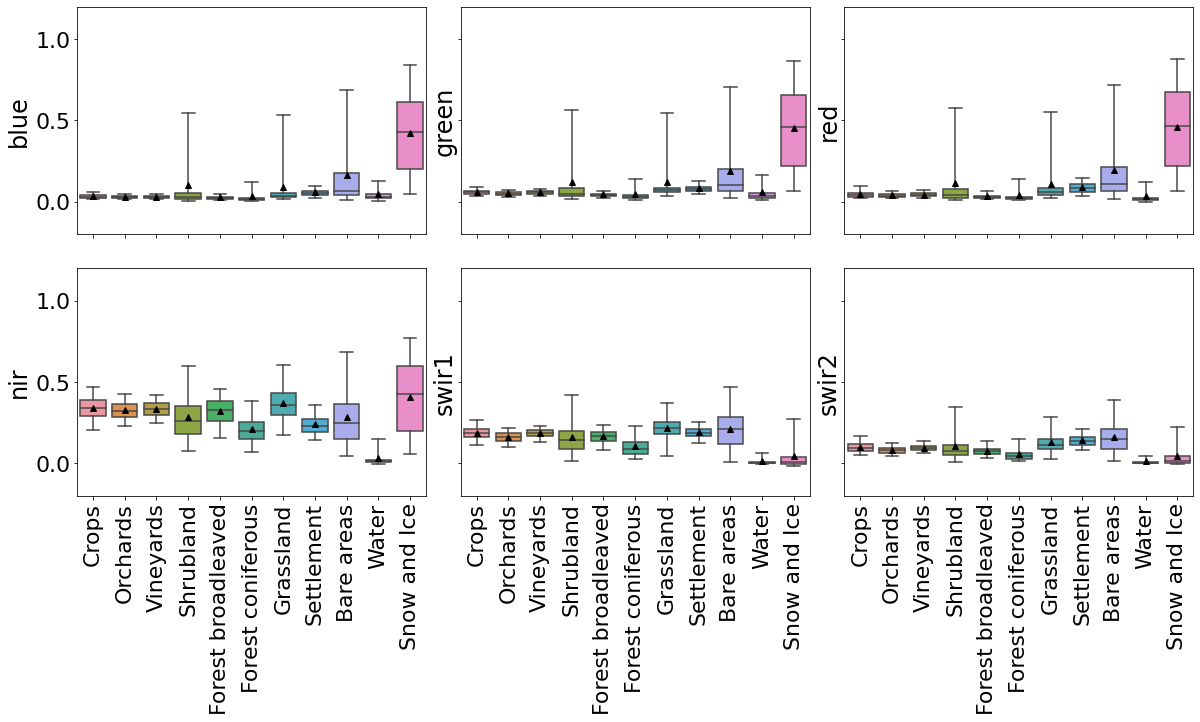

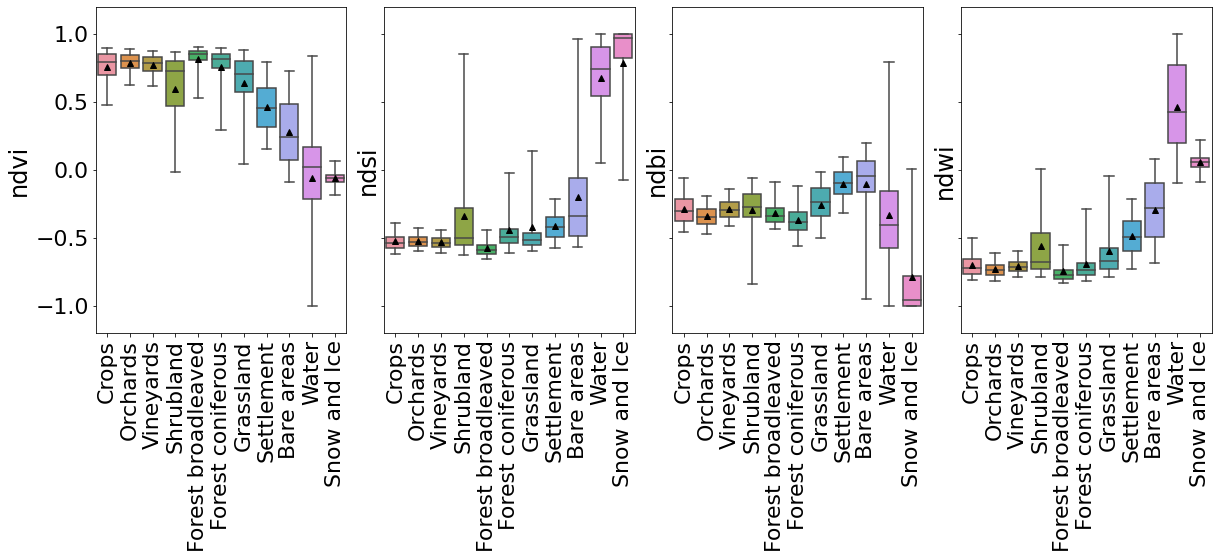

In [9]:
# iterate over tiles and plot distribution
for tile in TILES:
    # convert xarray.Dataset to pandas.DataFrame
    ds = train_ds[tile].to_dataframe(dim_order=('samples', 'time'))

    # map class identifiers to class labels
    ds['class'] = ds['label'].map(class_labels)
    ds = ds.drop(columns=['x', 'y', 'label'])
    ds = ds.reindex(columns=[*USE_BANDS[:-1], *INDEX_FEATURES, 'class'])
    plot_spectral_bands(ds)
    plot_spectral_indices(ds)

### Linear discriminants

In [10]:
# compute distribution over time and concatenate training data of different tiles
feature_ds = [TrainingDataFactory.features(tile, TrainingDataFactory.percentiles) for tile in train_ds.values()]
feature_ds = xr.concat(feature_ds, dim='samples')
feature_ds

<xarray.Dataset>
Dimensions:   (features: 9, samples: 27500)
Coordinates:
    x         (samples) int64 2519 2812 3611 3580 2893 ... 781 775 784 775 779
    y         (samples) int64 51 57 183 191 218 227 ... 3061 3064 3067 3071 3077
  * features  (features) float64 0.01 0.05 0.1 0.25 0.5 0.75 0.9 0.95 0.99
Dimensions without coordinates: samples
Data variables:
    blue      (features, samples) float64 0.009154 0.01768 ... 0.734 0.8028
    green     (features, samples) float64 0.02478 0.04177 ... 0.737 0.8033
    label     (features, samples) float64 1.0 1.0 1.0 1.0 ... 11.0 11.0 11.0
    nir       (features, samples) float64 0.2441 0.2128 0.2077 ... 0.6954 0.7204
    red       (features, samples) float64 0.01535 0.02635 ... 0.7796 0.8096
    swir1     (features, samples) float64 0.07756 0.1444 ... 0.03495 0.1104
    swir2     (features, samples) float64 0.03306 0.06865 ... 0.04666 0.1066
    ndvi      (features, samples) float64 0.1177 0.04044 ... 0.03242 0.01271
    ndsi      (features, samples) float64 -0.6291 -0.5551 -0.5172 ... 1.0 1.0
    ndbi      (features, samples) float64 -0.5804 -0.415 ... -0.9045 -0.6791
    ndwi      (features, samples) float64 -0.8356 -0.7863 ... 0.1142 0.1021